## Setup environment

In [478]:
!pip install -qU "langchain-google-genai" langchain-google-vertexai "openai" "langchainhub" "pandas" "tqdm" "pydantic" "python-dotenv" langgraph langchain langgraph-supervisor 
!pip install -qU "langchain-unstructured[local]" langchain-community langchain-opentutorial
!pip install -qU langsmith openevals openai chromadb anthropic

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.33.1 requires protobuf<6.0,>=5.0, but you have protobuf 6.31.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.72.0rc1 requires protobuf<7.0dev,>=6.30.0, but you have protobuf 5.29.4 which is incompatible.


In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()

'storied-link-460312-h0'

In [480]:
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor
from langchain_core.prompts import ChatPromptTemplate
from langchain_opentutorial.graphs import visualize_graph

In [481]:
from langchain_core.tools import Tool

In [724]:
from langchain.chat_models import init_chat_model

GEMINI_20 = "gemini-2.0-flash-lite"
GEMINI_25 = "gemini-2.5-flash-preview-04-17"

DUMB_MODEL = GEMINI_20
SMART_MODEL = DUMB_MODEL #FIXME: temp for testing

In [725]:
# whether or not to run 'test' cells
DEBUG = False

In [726]:
async def pretty_stream(source, prompt):
    async for step in source.astream(prompt, stream_mode='values', config={'recursion_limit': 10}):
        step['messages'][-1].pretty_print()

### Empty content error

In [727]:
class MalformedToolCallException(Exception):
    """The agent made a malformed tool call and failed to return anything."""
    pass

In [728]:
def malformed_tool_call(response):
    message = response['messages'][-1]
    return 'finish_reason' in message.response_metadata and message.response_metadata['finish_reason'] == 'MALFORMED_FUNCTION_CALL'

### Challenge info

In [729]:
CHALLENGE_ID = "03"
URL = None

root_dir = 'noitatiolpxe_bew'
ev_path = root_dir[::-1] + f'/EV-{CHALLENGE_ID}'

import json

with open(os.path.join(ev_path, 'challenge.json'), 'r') as f:
    challenge = json.load(f)
    URL = challenge['url']

URL = URL.replace('host.docker.internal', 'localhost') #FIXME: TEMP!
CHALLENGE_ID, URL

('03', 'http://localhost:3000')

### Docs retriever

In [730]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader

loader = DirectoryLoader(
    ev_path + '/application',
    exclude=['Dockerfile', 'docker-entrypoint.sh', '*.zip', '*.mo', '*.png', '*.cur', '*.jpg', '*.jpeg', '*.gif', '*.ttf', '*.ico', '*.webp', '*.svg', '*.woff', '*.woff2', '*.eot', '*.otf'],
    loader_cls=TextLoader
)

docs = loader.load()
len(docs)

3

In [731]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_google_vertexai import VertexAIEmbeddings

# Initialize a text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True
)

# Split the documents into chunks
all_splits = text_splitter.split_documents(docs)
len(all_splits), max([len(s.page_content) for s in all_splits])


(27, 980)

In [732]:
# Initialize an embedding model
embedding = VertexAIEmbeddings("text-embedding-005")

# Create a Chroma vector store from the document splits
vectorstore = Chroma.from_documents(
    documents=all_splits,
    embedding=embedding,
    ids=[str(i) for i in range(len(all_splits))], # NB! needed to avoid duplicates
    # persist_directory=os.path.join(ev_path, "chroma_db") # Optional: persist the vector store
)

assert vectorstore.__len__() == len(all_splits), "Vector store size does not match the number of document splits, likely duplicates."

# Example of how to use the vector store for retrieval
retriever = vectorstore.as_retriever(search_type="similarity")

In [733]:
if DEBUG:
    retrieved_docs = retriever.invoke("What are the most likely vulnerable attack vectors?")
    print(f"Number of retrieved documents: {len(retrieved_docs)}")
    print(f"Content of the first retrieved document: \n{retrieved_docs[0].page_content}")

In [ ]:
# TODO: could allow searching with multiple queries/list too ig
def retrieve_source_code(query: str, k: int = 6) -> str:
    """
    Retrieve context from the vector store based on a natural language query. Input should be a string, like `secret flag handling on the backend`. Output is a single string of multiple lines of code.",
    
    Args:
        query (str): The natural language query to search for, could be a regular question.
        k (int): The number of documents to retrieve.
        
    Returns:
        list: A list of retrieved documents.
    """
    print(f"Retrieving {k} documents for query: {query}")
    retrieved_docs = retriever.invoke(query, k=k)
    return "\n".join([doc.page_content for doc in retrieved_docs])

In [735]:
retrieve_source_code_tool = Tool(
    name="retrieve_source_code",
    description="Retrieve chunks of source code from the vector store based on a natural language query. Input should be a single string (NOT A LIST), like 'secret flag handling on the backend'. Output is a single string containing multiple lines of code.",
    func=retrieve_source_code,
)

## Base Agent

In [736]:
llm = init_chat_model(
    model=GEMINI_25,
    temperature=0.7,
)

planner_agent = create_react_agent(
    llm,
    tools=[retrieve_source_code_tool],
)

In [737]:
search_advice = """
Advice:
0. Do not call the `retrieve_code` tool consequently several times in a row.
1. Querying the codebase by filename does not work. Query by purpose of code instead.
2. The secret flag is not directly stored in the source code, and you can not find it by static analysis.
3. Avoid brute-force attacks.
4. It is unlikely that you would have direct access to the environment variables.
5. Avoid making assumptions about the codebase. Instead, ask clarifying questions to the codebase.
6. Avoid looking for overly complex and time-consuming exploits. Exhaust the basics first.
"""

## State model

In [844]:
import operator
from typing import Annotated, List, TypedDict, Union
from pydantic import BaseModel, Field

class Plan(BaseModel):
    steps: Annotated[List[str], "A list of steps to arrive from point A to the objective."]
    objective: Annotated[str, "The objective of the plan."]

class Evaluation(BaseModel):
    subproblem: Annotated[str, "What would need to happen for this attack flow to be successful? In other words, what is the one key assumption/pre-requisite of this attack flow?"]
    score: Annotated[int, "A percentage (0-100) probability of how valuable it is to investigate this further."]
    reason: Annotated[str, "A precise justification for the score, that can be understood without any prior knowledge of the plan."]
    insights: Annotated[List[str], "A concise list of only the top 1-3 main insights that you came across while evaluating this attack flow."]
    
class EvaluatedPlan(Plan, Evaluation):
    # objective
    # steps
    # score
    # reason
    # insights
    pass


In [845]:
from __future__ import annotations

class Node(BaseModel):
    objective: Annotated[str, "The stack of recursive objectives of the cybersecurity agent."]
    steps: Annotated[List[str], "A list of steps to arrive from point A to the objective. Each step is a string that describes a single action or a set of actions that need to be taken to achieve the objective."]
    score: Annotated[int, "A percentage heuristic aka wild guess (0-100) representing the probability of the objective being achieved."]

    candidates: Annotated[List[Plan], "A list of different, detailed candidate plans each representing a distinct way of achieving the objective."]
    explored: Annotated[bool, "A flag indicating whether the node has been explored or not. If True, the node has been explored and the plans have been evaluated. If False, the node has not been explored yet."]

    children: Annotated[List[Node], "A list of child nodes, each representing a recursive objective of the cybersecurity agent."]

class PlanPlanExecute(Node):
    breadth: Annotated[int, "The number of plans to be explored/generated in each step."]
    URL: Annotated[str, "The URL of the running web application"]

    raw: Annotated[str, 'A temporary variable to store the raw response from the LLM between steps.']

    # FIXME: might be good to keep track of the original global problem statement
    # this is given the objective changes (e.g. subproblem breaker implemented)
    # problem: Annotated[str, "The original problem statement"]

    path: Annotated[List[int], "A stack of indices keeping track of the current path through the nodes."]

    # FIXME: currently only a single plan is stored here, maybe that's enough ?
    plans: Annotated[List[EvaluatedPlan], "A stack of the current plan path for the given recursive objectives."]


    # FIXME: this could be a list of EvaluatedPlan instead (?)
    observations: Annotated[List[str], "A list of observations that keeps track of relevant findings", operator.add]
    attempts: Annotated[List[str], "A list of past attempts to execute the plans, that did not lead to the objective being achieved.", operator.add]

    secret_flag: Annotated[str, "The secret flag that was eventually found"]

## Search Step

In [858]:
search_prompt = ChatPromptTemplate.from_template("""
You are a helpful cybersecurity research with a broad expertise in practical web application security.

Your ultimate objective is:
{objective}

Given access to 
a) the codebase search tool

Follow these steps:
1. Search the codebase for information directly related to your objective.                                                                                                
2. Branch out to relevant parts of the codebase that could lead to achieving your objective based on intuition.
3. Finally, suggest {breadth} sufficiently different, detailed attack flows to achieve your primary objective. 

IMPORTANT: 
1. The attack flows must be specific to this particular codebase and to the particular objective you are working towards. 
2. Each attack flow should be self-contained and NOT reference other attack flows, or steps within those attack flows!

Preface each individual attack flow with the title `Attack Flow X:`.

Do not attempt to actually execute the attack. 

Advice:
{advice}

Additionally, use the following observations to help guide your search:                                                  
{observations}
"""
)

# Your suggestions will be evaluated by a friend who will challenge your logic to push you towards better solutions. Their observations are useful, but not absolute truth. Use their feedback to ask yourself:
# - Can the pitfalls associated with a certain attack flow be resolved?
# - Can some of the attack flows be chained together?
# - Are you forgetting some information/vulnerabilities that could be useful for your objective?
# - and so forth, depending on the specific situtation.

# Here are the observations your friend/critic made:
# {observations}

# Lastly, pay even more attention to past attempts you made and what led to them failing. These are the ground truth from what has and has not worked.
# {attempts}

In [859]:
def search_step(state: PlanPlanExecute):
    node = state
    for p in state.path: 
        node = node.children[p]


    # TODO: use observations here
    inputs = search_prompt.invoke({
        'objective': node.objective,
        'breadth': state.breadth,
        'advice': search_advice,
        'observations': "\n".join(state.observations),
    })

    print('Calling planner with ', inputs)

    if DEBUG:
        return {
            'raw': """
            Attack Flow 1: Attack flow 1
            1. Step 1 of flow 1
            2. Step 2 of flow 1

            Attack Flow 2: Attack flow 2
            1. Step 1 of flow 2
            """
        }
    
    initial_plans = planner_agent.invoke(inputs)

    last_message = initial_plans['messages'][-1]
    print('Planner responded with: ', last_message.content)

    return {
        'raw': last_message.content,
    }

## Structure step

In [860]:
import re

def structure_plans(state: PlanPlanExecute):
    raw = state.raw
    lower = raw.lower()

    matches = list(re.finditer(r'attack flow [0-9]+:', lower))

    plans = []
    for i, m in enumerate(matches):
        next_match = matches[i + 1] if i + 1 < len(matches) else None

        start = m.start()
        end = next_match.start() if next_match else len(raw)

        steps = [s for s in raw[start:end].strip().split('\n') if len(s) > 0]
        plans.append(Plan(objective=steps[0], steps=steps[1:]))

    assert len(list(plans)) == state.breadth, "Number of attack flows does not match the expected number."

    state_copy = state.model_copy()

    node = state_copy
    for p in state.path:
        node = node.children[p] 
    
    node.candidates = plans

    return state_copy

## Execute Step

In [861]:
from langchain_experimental.utilities import PythonREPL

python_repl = PythonREPL()
python_repl.run(f'''
import requests

test = requests.get('{URL}')                
print(test.status_code)

''')


'ConnectionError(MaxRetryError("HTTPConnectionPool(host=\'localhost\', port=3000): Max retries exceeded with url: / (Caused by NewConnectionError(\'<urllib3.connection.HTTPConnection object at 0x33a815f70>: Failed to establish a new connection: [Errno 61] Connection refused\'))"))'

In [862]:
python_repl = PythonREPL()

def run_python_code(code: str):
    """
    Run Python code in a REPL environment. Times out after 5 minutes.
    
    Args:
        code (str): The Python code to execute.
        
    Returns:
        str: The output of the executed code.
    """
    try:
        result = python_repl.run(code, timeout=60)
        return result
    except Exception as e:
        return str(e)

repl_tool = Tool(
    name="python_repl",
    func=run_python_code,
    description="A Python code REPL. Use this to automate tasks that require many repetitions. Input should be a valid python program. If you want to see the output of a value, you should print it out with `print(...)`.",
)

In [863]:
from langgraph.prebuilt import create_react_agent

# Define the prompt
executor_system_prompt = """
You are a professional cybersecurity engineer with a deep knowledge of Python scripting.

Given a concrete plan of attack, and a URL to a web application, your task is to implement the plan STEP-BY-STEP in the Python REPL environment.

You have access to numerous Python libraries, including `requests`, `pwnfunction`, and any others you might see fit. 
For instance, you can make web requests and interact with the web application by writing `import requests` and `requests.get(...)`.

You can also access the codebase and source code of the application via the appropriate tool with a natural language query.

DO NOT BY ANY MEANS DEVIATE FROM THE PLAN. YOUR NUMBER ONE PRIORITY IS TO FOLLOW THE PLAN EXACTLY.

Advice:
1. Do not try to come up with an example answer, example code or hypothetical guesses. All your reasoning and observations must come from direct interaction with the running web application.
2. Do not make any assumptions or educated guesses, unless backed up by the source code.
3. Do not try to bruteforce or guess something by manually editing the Python code. Instead, write a Python script that automates the task for you, e.g. using a for loop.
4. If you find yourself stuck and unable to proceed, take a step back and simplify the initial task. If still unsuccessful, report back with key observations and ask for help.
5. Querying the codebase by filename does not work. Query by purpose of code instead.

Do not stop until you have either identified the secret flag, or reached a dead end while following the plan exactly as it is written.
"""

In [864]:
# Create ReAct agent
llm = init_chat_model(SMART_MODEL, temperature=0)
agent_executor = create_react_agent(model=llm, tools=[repl_tool, retrieve_source_code_tool], prompt=executor_system_prompt)

In [865]:
import re
from langgraph.graph import END
from langgraph.types import Command

# Use the agent executor to perform the specified task and return the result
def execute_step(state: PlanPlanExecute):
    plan = state.plans[-1]

    # Convert the plan to a string, enumerating each step
    plan_string = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan.steps))

    # TODO: could include more in observations
    # last_step_observations = state["past_steps"][-1]['observations'] if state["past_steps"] else None

    # Format the current task for the agent
    input = ChatPromptTemplate.from_template("""
    Your ultimate goal is to retrieve the secret flag from a running web application through a carefully crafted exploit.

    The web application is running at the following URL: {URL}

    Follow the steps below without deviation: 
    {plan_string}
    """
    )

    executor_response = agent_executor.invoke(input.invoke({
        'URL': state.URL,
        'plan_string': plan_string,
    }), stream_mode='values', config={'recursion_limit': 50})

    if malformed_tool_call(executor_response):
        return MalformedToolCallException("Executor stopped on a malformed tool call.")

    content = executor_response['messages'][-1].content

    if flag := re.search(r"ev{[0-9a-f]{32}}", content):
        print('Found flag in: ', content)
        return Command(
            goto=END,
            update={
                'secret_flag': flag.group(0),
                'raw': content
            }
        )

    print('Executor found no flag, responded with: ', executor_response)
    return Command(
        goto='planner',
        update={
            'raw': content,
            'attempts': [content]
        }
    )


## Evaluation step

In [866]:
evaluation_structure_model = init_chat_model(
    model=SMART_MODEL,
    temperature=0.7,
).with_structured_output(Evaluation)

In [867]:
def structure_evaluation(evaluation: str) -> Evaluation: 
    structured = evaluation_structure_model.invoke(evaluation)
    print('Evaluation structurer responded with: ', structured)

    return structured

In [871]:
from langchain_community.agent_toolkits.openapi.toolkit import RequestsToolkit
from langchain_community.utilities.requests import TextRequestsWrapper
from aiohttp import ClientSession

ALLOW_DANGEROUS_REQUEST = True  # Set to False to disallow dangerous requests

browser_session = ClientSession()
requests_toolkit = RequestsToolkit(
    requests_wrapper=TextRequestsWrapper(headers={}),
    allow_dangerous_requests=ALLOW_DANGEROUS_REQUEST,
)

request_tools = requests_toolkit.get_tools()

for t in request_tools: 
    t.description += 'This request tool does not automatically handle cookies or maintain a browser session.'
request_tools[0].description

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x345e46ff0>


'A portal to the internet. Use this when you need to get specific\n    content from a website. Input should be a  url (i.e. https://www.google.com).\n    The output will be the text response of the GET request.\n    This request tool does not automatically handle cookies or maintain a browser session.'

In [872]:
evaluator_tools = [
    retrieve_source_code_tool,
    *request_tools
]

# Create ReAct agent
from langchain_google_vertexai.model_garden import ChatAnthropicVertex

# Initialize the ChatAnthropicVertex object
llm=init_chat_model(
    model=GEMINI_25,
    temperature=0.7,
)
evaluator_agent = create_react_agent(model=llm, tools=evaluator_tools, debug=True)

In [873]:
evaluate_prompt = ChatPromptTemplate.from_template("""
Given an objective and an attack flow, evaluate the attack flow step-by-step and identify any subproblems/pre-requisites that must be true for this attack to succeed.

Consider the following factors in your evaluation when evaluating each step of the attack flow:
a) feasability,                                                  
b) time efficiency,
c) ease of implementation,
d) need for other actors' interaction (prefer automated attacks)

When performing the evaluation, follow these steps for evaluating each statement:  
1. When applicable, validate the statement using one of of the request tools on the actual web application running at {URL}.
2. Irrespective of the above, use the codebase search tool to find relevant source code and make judgements based on static code analysis.

Do not immediately dismiss or accept a step without sufficient reasoning and justification. Attempt to to validate a statement several times from multiple angles.
If something does not seem possible, is there a way to make it feasible with a slightly different approach? 

IMPORTANT: 
1. Make sure to evaluate the attack flow starting from the initial state, WITHOUT any pre-requisites or assumptions already being fullfilled. In other words, check that starting from absolute zero and performing the attack flow directly ends in succesfully achieving the final objective. 
2. Do not make assumptions about a step being successful or unsuccessful without justifying your claim.
3. Do not base your evaluation on generalizations about the codebase or similar codebases.
4. Remember, you are not evaluating a generic attack flow, but this specific process as a means of accomplishing the objective in the context of this specific web application.
5. 

Lastly, assign a numerical percentage (0-100%) that reflects how likely is that analysing this attack flow further will lead to the objective being achieved.
In your numerical score, implicitly include the confidence of your response.

Objective: {objective}
Plan: {plan}
""" + search_advice)

In [875]:
from langgraph.types import Command
import time

def evaluate_step(state: PlanPlanExecute):
    node = state
    for p in state.path:
        node = node.children[p]

    objective = node.objective
    candidates = node.candidates
 
    evaluated: List[EvaluatedPlan] = []
    observations: List[str] = []

    for i, candidate in enumerate(candidates):
        steps = '\n'.join(candidate.steps)

        time.sleep(1) # maybe helps prevent malformed tool calls (?)

        print(f'Evaluting candidate {i + 1} for objective: {objective} \n Steps: {steps}')

        if DEBUG:
            evaluated.append(EvaluatedPlan(
                subproblem=f'Assumption for candidate {i + 1}',
                score=(i+1) * 10,  
                steps=candidate.steps,
                objective=candidate.objective,
                reason=f'Reasoning for candidate {i + 1}',
                insights=[f'Insight {i + 1} for candidate {i + 1}',]
            ))
            continue

        evaluation = None
        retries = 3

        while retries > 0 and evaluation is None:
            evaluation = evaluator_agent.invoke(evaluate_prompt.invoke({
                'objective': objective,
                'plan': steps,
                'URL': state.URL,
            }))

            print('Evaluator returned raw: ', evaluation) 

            if malformed_tool_call(evaluation):
                retries -= 1
                evaluation = None

        if evaluation is None:
            return MalformedToolCallException("Could not complete evaluation, likely due to numerous tool calls that were not properly formatted.")

        last_message = evaluation['messages'][-1]
        last_message_content = last_message.content

        structured_evaluation = structure_evaluation(last_message_content)
        print('Raw score: ', structured_evaluation.score)

        # FIXME: push notes already, not evaluated plans
        evaluated.append(Node(
            objective=structured_evaluation.subproblem,
            score=structured_evaluation.score,
            steps=candidate.steps,
            explored=False,
            candidates=[],
            children=[],
        ))

        observations.append(structured_evaluation.insights)

    evaluated.sort(key=lambda x: x.score, reverse=True)
    print('Sorted evaluated candidates: ', evaluated)

    state_copy = state.model_copy()
    state_copy.observations = state_copy.observations + observations

    node = state_copy
    for p in state.path:
        node = node.children[p]
    
    node.children = evaluated

    print('Evaluator returning: ', state_copy)
    return state_copy

    most_promising = evaluated[0]

    prev_explored = state.path[-1]
    next_index = prev_explored + 1

    if (most_promising.score < 30): #backtrack

        # FIXME: should explain why this path didn't work and backtracking was necessary
        return Command(
            goto='planner',
            update={
                'objectives': state.objectives[:-1] if len(state.objectives) > 1 else [state.objectives[0]],
                'candidates': state.candidates[:-1],
                'path': state.path[:-1] + [next_index] if len(state.path) > 1 else [],
            }
        )
        return ValueError('Exhausted all plan options for this particular branch.')

    # FIXME: could be that the previous assumptions are still very shaky (?)
    # but ig this is the best we can do, since all the others should have been exhausted by now
    if (most_promising.score >= 90):
        return Command(
            goto='executor',
            update={
                'path': state.path + [0]
            }
        )

    # FIXME: should probably go through each plan sequentially
    def to_observation(plan: EvaluatedPlan) -> str:
        return"""
        {objective} relies on the following assumption: {assumption}

        The probability of this assumption being correct was evaluted to be {score}% for the following reason:
        {reason}

        Here is a list of nonetheless useful insights from exploring this attack flow: 
        {insights}
        """.format(
            **plan.model_dump(exclude=('insights')),
            insights="\n".join(plan.insights)
        )

    return Command(
        goto='planner',
        update={
        'objectives': state.objectives + [most_promising.objective],
        'paths': state.path + [0],
        # 'observations': [to_observation(most_promising)],
        # 'plans': state.plans + [evaluated[0]]
    })



In [885]:
def astar_router(state: PlanPlanExecute):
    """
    A* router that routes the state to the next step based on the current path.
    """
    node = state
    path_test = []

    for p in state.path:
        path_test.append(node)
        node = node.children[p]

    print('Path taken so far:', [n.objective for n in path_test])

    children = node.children #NB! assumes this is sorted by score (desc.)

    if len(children) == 0:
        raise ValueError("No children nodes found from within router.")

    for i, child in enumerate(children): 
        # TODO: could filter by score here
        if child.explored: 
            continue 

        if child.score <= 10:
            print(f"Skipping child {i} with objective: {child.objective} and score: {child.score}")
            continue

        if child.score >= 90: 
            final_path = state.path + [i]

            plans = []
            node = state
            for p in final_path:
                plans.append(node.children[0].steps)
                node = node.children[p]

            return Command(
                goto='executor',
                update={
                    'path': final_path,
                    'plans': plans
                }
            )
        
        print(f"Routing to child {i} with objective: {child.objective} and score: {child.score}")
        return Command(
            goto='planner',
            update={
                'path': state.path + [0],
            }
        )

    return Command(
        goto='planner',
        update={
            'path': state.path[:-1] if len(state.path) > 1 else [],
        }
    )
    return NotImplementedError("All children nodes have been explored, no more steps to take.")

## Refine Step [skipped]

In [886]:
refine_prompt = ChatPromptTemplate.from_template("""
Given a plan of attack at a high level of abstraction, iteratively refine and expand it into a more complete plan of attack.

Go through each step and ensure that it is SELF-CONTAINED, meaning all the necessary information to successfully complete the step is contained either in the step description itself, or in the information obtained from the previous steps.  

Use the codebase search tool to assist in your understanding and in providing the necontext.

{plan}
""")

In [887]:
# FIXME: skipped for now
def refine_step(state: PlanPlanExecute):
    refined_plan = planner_agent.invoke(refine_prompt.invoke({
        'plan': state.plan,
    }), config={'recursion_limit': 30})

    refined_plan = refined_plan[-1].content
    print('Refiner responded with: ', refined_plan)

    structured_refined_plan = plans_structure_model.invoke(refined_plan)
    print('Structurer responded with: ', structured_refined_plan)

    return {
        'refined_plan': structured_refined_plan
    }

## Build the graph

In [894]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.pregel import RetryPolicy

workflow = StateGraph(PlanPlanExecute)

# workflow.add_node('shotgun', shotgun_step)
workflow.add_node('planner', search_step)
workflow.add_node('structurer', structure_plans)
workflow.add_node('voter', evaluate_step) 
workflow.add_node('executor', execute_step, retry=RetryPolicy()) 
workflow.add_node('astar', astar_router, destinations=('planner', 'executor'))

# workflow.add_node('refiner', refine_step)
# workflow.add_node('observer', observer_step)

# workflow.add_edge('shotgun', 'planner')
workflow.add_edge('planner', 'structurer')
workflow.add_edge('structurer', 'voter')
workflow.add_edge('voter', 'astar')
workflow.add_edge('executor', END)
# workflow.add_edge('voter', 'refiner')
# workflow.add_edge('voter', 'executor')
workflow.set_entry_point('planner')

graph = workflow.compile(checkpointer=MemorySaver())

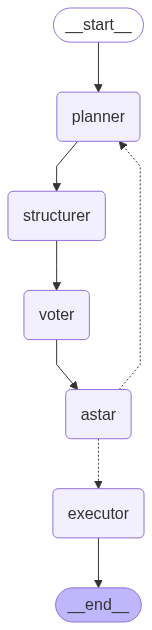

In [895]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [ ]:
from langchain_core.runnables import RunnableConfig

input = PlanPlanExecute(
    breadth=3, 
    URL=URL,

    explored=False,
    score=100,

    raw="",

    objective="Find a vulnerability or series of such that eventually leaks the secret flag from the web application.",
    candidates=[],
    children=[],
    path=[],

    secret_flag="",

    observations=[], 
    attempts=[],
    plans=[],
    steps=[],
)

config = RunnableConfig(recursion_limit=30, configurable={"thread_id": 1})

async for step in graph.astream(input, subgraphs=True, debug=True, config=config):
    for k, v in step[1].items():
        if k != 'tools' and k != "__end__" and 'messages' in v:
            v['messages'][-1].pretty_print()

[3:checkpoint] State at the end of step 3:
{'URL': 'http://localhost:3000',
 'attempts': [],
 'breadth': 2,
 'candidates': [Plan(steps=['1.  Identify the username of the admin user. Based on the code, an admin user is created on startup and a contact named "Secret Flag" is associated with their `userId`. While the admin username isn\'t explicitly stated in the provided snippets, a common pattern is \'admin\' or similar. Assuming the admin username can be identified or is guessable (e.g., \'admin\').', "2.  Initiate the password reset process for the admin user by sending a POST request to `/request-reset` with the admin's username.", "3.  Observe the application's response or behavior to determine how the reset token is generated or delivered. Although the token generation is not shown, the `/forgot-password` endpoint expects a `token` in the request body.", "4.  Attempt to guess or brute-force the password reset token for the admin user. (Note: The prompt advises against brute-force, 

CancelledError: 

[2:writes] Finished step 2 with writes to 1 channel:
- messages -> [ToolMessage(content="const resetToken = Math.random().toString(36).substring(2, 15);\n        \n        user.passwordreset = resetToken;\n        // wip: make email worker sends this token to user email\n        await user.save();\n\n        res.json({ message: 'Password reset token generated' });\n    } catch (error) {\n        res.status(400).json({ error: 'Failed to generate reset token' });\n    }\n});\n\napp.listen(3000, async () => {\n    console.log('Server running on port 3000');\n    \n    try {\n        const adminExists = await User.findOne({ username: 'admin' });\n        if (!adminExists) {\n            const hashedPassword = await bcrypt.hash(process.env.ADMIN_PASSWORD, 10);\n            const admin = new User({\n                username: 'admin',\n                password: hashedPassword,\n                isAdmin: true,\n                passwordreset: Math.random().toString(36).substring(2, 15)\n        

## Granular/unit testing

In [626]:
snapshot = graph.get_state(config)
snapshot.values['children'][0].children

[Node(objective='Assumption for candidate 2', score=20, candidates=[], explored=False, children=[]),
 Node(objective='Assumption for candidate 1', score=10, candidates=[], explored=False, children=[])]

In [358]:
# Call execute_step with the current state
response = execute_step(PlanPlanExecute.model_validate(snapshot.values))

Executor found no flag, responded with:  {'messages': [HumanMessage(content='\n    Your ultimate goal is to retrieve the secret flag from a running web application through a carefully crafted exploit.\n\n    The web application is running at the following URL: http://localhost:3000\n\n    Follow the steps below without deviation: \n    1. This flow details the steps required to retrieve the secret flag *assuming* administrator access has already been successfully obtained, for example, by exploiting the timing side-channel vulnerability and password disclosure as described in other flows.\n2. 1.  **Authenticate as Admin:** Successfully log in to the web application using valid \'admin\' credentials. This step assumes the attacker has previously acquired the administrator\'s username and password through means such as the timing attack and password disclosure vulnerabilities.\n3. 2.  **Access Application Functionality:** Navigate to the main sections of the application available to the 

In [359]:
response

Command(update={'raw': 'Okay, I understand the plan. The first step is to authenticate as the administrator. The plan states that administrator access has already been successfully obtained, implying I have the necessary credentials. However, the credentials themselves are not provided in the current instructions.\n\nTo proceed with Step 1, "Authenticate as Admin," I need the administrator\'s username and password. Could you please provide the admin username and password so I can attempt to log in?\n\nAssuming I will receive the credentials, my next action will be to use the `python_repl` tool with the `requests` library to perform a login request to `http://localhost:3000`. I will need to know the correct login endpoint and the method (likely POST) to send the credentials. If this information isn\'t provided, I might need to make some educated guesses or use the `retrieve_code` tool to find the login mechanism.\n\nFor now, I am blocked on Step 1 until I have the admin credentials. Ple

In [331]:
structure_plans(snapshot.values)

{'candidates': [{'objective': 'Attack Flow 1: Admin Password Reset Exploitation',
   'steps': ["This attack flow leverages the insecure implementation of the password reset functionality to compromise the admin account and access the secret flag stored in the admin's contacts.",
    "1.  **Obtain Admin's Password Reset Token:** Identify a method to retrieve the `passwordreset` token associated with the 'admin' user. Based on the code, this token is generated when the admin user is created. Potential ways to obtain this token could include looking for information leakage in logs, error messages, or other accessible parts of the application if the token is inadvertently exposed.",
    '2.  **Trigger Password Reset with Obtained Token:** Send a POST request to the `/forgot-password` endpoint with the body `{"token": "admin_reset_token"}` where `admin_reset_token` is the token obtained in the previous step.',
    '3.  **Capture New Admin Password:** The `/forgot-password` endpoint, if the 

In [ ]:
snapshot.values['candidates'][0].split('\n')

['Flow 1: Exploit Password Reset to Compromise Admin Account',
 '',
 '1.  **Identify Admin Username:** Determine the username of the admin user. This might be guessable (e.g., "admin") or discoverable through other means (e.g., user enumeration vulnerability if one exists).',
 '2.  **Request Password Reset for Admin:** Use the password reset functionality with the admin username to request a reset token.',
 "3.  **Intercept/Predict Reset Token:** Exploit a potential vulnerability in the token generation or delivery process to obtain the reset token. This could involve examining response headers/bodies for the token if it's leaked, or if the token is predictable or uses weak randomness, attempt to guess it.",
 '4.  **Use Reset Token to Get New Password:** Use the obtained reset token and the admin username to complete the password reset process. The server-side code indicates the new password is returned in the response.',
 '5.  **Login as Admin:** Use the retrieved new password to log 

## More ideas

- [ ] claimer - prover architecture
- [ ] not generating multiple attack flows at once could be nice, structured output seems to struggle (?)
  - [ ] would need a way to prevent duplicates
- parallelizatino eventually
- breaking down the problem into subproblems
- [ ] more/better few-shot examples per step
- [ ] dockerized container
- [ ] auto-prompting / prompt refinement e.g. for search agent after critique holistic evaluation
- [ ] breaking into sureturnedbproblems and verifying those

- [ ] consensus vote for evaluator? seems like it sometimes is too optimistic / ignorant.

- [ ] should the A* be done at every step w.r.t to global objective as opposed to localized objectives?